In [230]:
import pandas as pd
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from math import pi
from tensorflow.keras.layers import GRU
import numpy as np
import seaborn as sns

from mint.config import DATA_DIR

In [231]:
# CONFIG
ViABSA_BP_dir = path.join(DATA_DIR, 'ViABSA_BP')

train_file = path.join(ViABSA_BP_dir, 'data_train.csv')
test_file = path.join(ViABSA_BP_dir, 'data_test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [232]:
train_df.head()

,data,stayingpower,texture,smell,price,others,colour,shipping,packing
0,"son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...",NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN
1,Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...,NaN,positive,positive,positive,NaN,NaN,NaN,NaN
2,"Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...",NaN,negative,NaN,NaN,NaN,positive,NaN,NaN
3,Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...,positive,positive,NaN,NaN,NaN,positive,NaN,NaN
4,"Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive


In [233]:
# SET-UP DATA
aspects = train_df.columns[1:]

train_df[aspects] = train_df[aspects].fillna("none")
test_df[aspects] = test_df[aspects].fillna("none")

for aspect in aspects:
  train_df[aspect + "_label"] = (train_df[aspect] != "none").astype(int)
  test_df[aspect + "_label"] = (test_df[aspect] != "none").astype(int)


aspect_labels = [aspect + "_label" for aspect in aspects]

X_train = train_df['data']
y_train_aspect = train_df[aspect_labels]
X_test = test_df['data']
y_test_aspect = test_df[aspect_labels]

train_df.head()

,data,stayingpower,texture,smell,price,others,colour,shipping,packing,stayingpower_label,texture_label,smell_label,price_label,others_label,colour_label,shipping_label,packing_label
0,"son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...",none,none,none,none,none,none,positive,none,0,0,0,0,0,0,1,0
1,Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...,none,positive,positive,positive,none,none,none,none,0,1,1,1,0,0,0,0
2,"Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...",none,negative,none,none,none,positive,none,none,0,1,0,0,0,1,0,0
3,Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...,positive,positive,none,none,none,positive,none,none,1,1,0,0,0,1,0,0
4,"Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...",none,none,none,none,none,none,none,positive,0,0,0,0,0,0,0,1


# **BiLSTM**

In [234]:
print(X_train.dtype)
print(y_train_aspect.dtypes)

object
stayingpower_label    int64
texture_label         int64
smell_label           int64
price_label           int64
others_label          int64
colour_label          int64
shipping_label        int64
packing_label         int64
dtype: object


In [235]:
vectorizer = TextVectorization()
vectorizer.adapt(X_train)

X_train_BiLSTM = vectorizer(X_train)
X_test_BiLSTM = vectorizer(X_test)

In [236]:
'''
    Nếu là multi-label (mỗi khía cạnh có thể xuất hiện độc lập) phải dùng activation='sigmoid' ở output layer, không dùng softmax
    softmax chỉ dùng cho multi-class (mỗi mẫu chỉ thuộc 1 lớp)
    - Softmax:
        Dùng cho multi-class (mỗi mẫu chỉ thuộc 1 lớp duy nhất)
        Tổng xác suất các lớp = 1
        Ví dụ: Phân loại cảm xúc (chỉ 1 trong 3: positive, neutral, negative)
    - Sigmoid:
        Dùng cho multi-label (mỗi mẫu có thể thuộc nhiều lớp cùng lúc)
        Mỗi output là xác suất độc lập (0-1) cho từng nhãn
        Ví dụ: Phát hiện các khía cạnh trong 1 câu, mỗi khía cạnh là 1 nhãn độc lập
'''

vocab_size = len(vectorizer.get_vocabulary())

# Cấu hình model BiLSTM
BiLSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100), 
    Bidirectional(LSTM(64)),
    Dense(len(aspect_labels), activation='sigmoid')
])

# Huấn luyện mô hình
# Dùng binary_crossentropy vì đang dùng sigmoid quy y về dạng 0 1
BiLSTM.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM.fit(X_train_BiLSTM, y_train_aspect)

# Dự đoán trên tập test
y_pred_aspect = BiLSTM.predict(X_test_BiLSTM)

406/406 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.2982 - loss: 0.4269
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [237]:
# Chuyển thành nhị phân (threshold 0.5) -> do dùng sigmoid trả về tập hợp từ [0; 1] nhưng y_pred_aspect cần 0 1
# >= 0.5 gán nhãn 1, < 0.5 nhãn 0
y_pred_aspect = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")


F1_ad (Aspect Detection): 0.8902


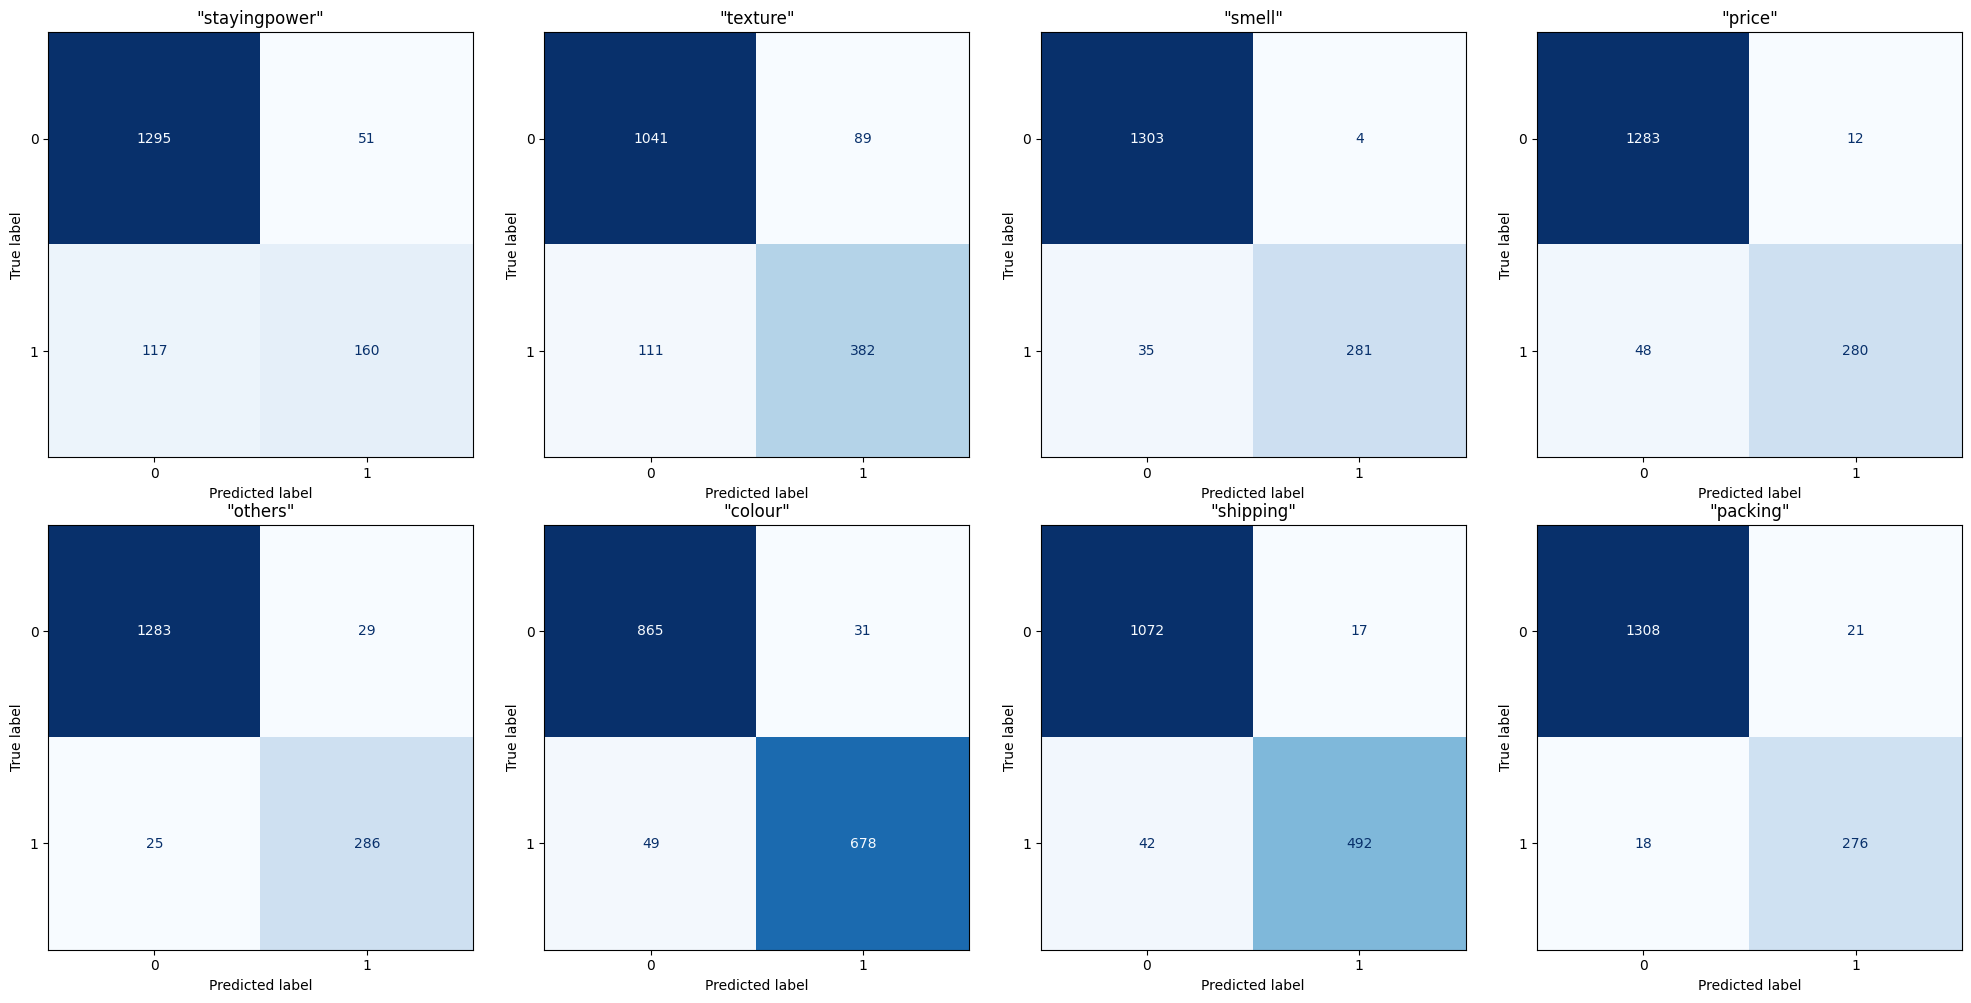

In [238]:
# Số cột mỗi hàng
cols = 4
total = len(aspects)
rows = (total + cols - 1) // cols 

# Tạo subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten() 

for i, aspect in enumerate(aspects):
    idx = aspects.get_loc(aspect)
    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'"{aspect}"')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [239]:
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': -1}

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
  y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
  y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

pipeline_sentiment = {}

for aspect in aspects:
  mask_train = train_df[aspect + '_label'] == 1
  X_train_aspect = train_df[mask_train]
  y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]

  if len(X_train_aspect) > 0:
    BiLSTM = Sequential([
        vectorizer,
        Embedding(input_dim=vocab_size, output_dim=100),
        Bidirectional(LSTM(64)),
        Dense(3, activation='softmax')])
    
    # Dùng sparse_categorical_crossentropy vì y là số nguyên (0, 1, 2)
    BiLSTM.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    BiLSTM.fit(X_train_aspect['data'].astype(str).values, y_train_aspect_sentiment.values)

    pipeline_sentiment[aspect] = BiLSTM

  else:
    pipeline_sentiment[aspect] = None

70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5524 - loss: 0.9465
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7088 - loss: 0.7672
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7463 - loss: 0.7122
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9295 - loss: 0.3098
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9318 - loss: 0.2913
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8110 - loss: 0.5830
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7067 - loss: 0.6908
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9526 - loss: 0.3854


In [240]:
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspects)), -1)

for i, aspect in enumerate(aspects):
    pipe = pipeline_sentiment[aspect]
    if pipe is not None:
        mask_pred = y_pred_aspect[:, i] == 1 
        if np.any(mask_pred):
            # Chuẩn hóa văn bản trước khi predict
            X_test_aspect = X_test[mask_pred].astype(str).values

            # Dự đoán sentiment
            y_pred_prob = pipe.predict(X_test_aspect)
            y_pred_label = np.argmax(y_pred_prob, axis=1)

            # Gán kết quả vào y_pred_sentiment
            y_pred_sentiment[mask_pred, i] = y_pred_label

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [241]:
f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] >= 0.5) & (y_test_sentiment[aspect] != -1) 
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, trung bình): {f1_sc:.4f}")

F1_sc (stayingpower): 0.6112
F1_sc (texture): 0.7660
F1_sc (smell): 0.7364
F1_sc (price): 0.9893
F1_sc (others): 1.0000
F1_sc (colour): 0.8230
F1_sc (shipping): 0.8814
F1_sc (packing): 0.9406

F1_sc (Sentiment Classification, trung bình): 0.8435


In [242]:
# F1_ad: F1-score trung bình trên tất cả các khía cạnh (multi-label)
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')

# F1_sc: F1-score trung bình trên tất cả các khía cạnh và cảm xúc (chỉ tính trên các khía cạnh được dự đoán và có nhãn cảm xúc hợp lệ)
f1_sc_list = []
for i, aspect in enumerate(aspects):
    # Chọn mẫu có khía cạnh được dự đoán và có nhãn cảm xúc hợp lệ (khác -1)
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)

In [243]:
# Kết quả 
f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0

print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")

F1_ad (Aspect Detection): 0.8902
F1_sc (Sentiment Classification): 0.8435



Confusion matrix cho khía cạnh 'stayingpower':


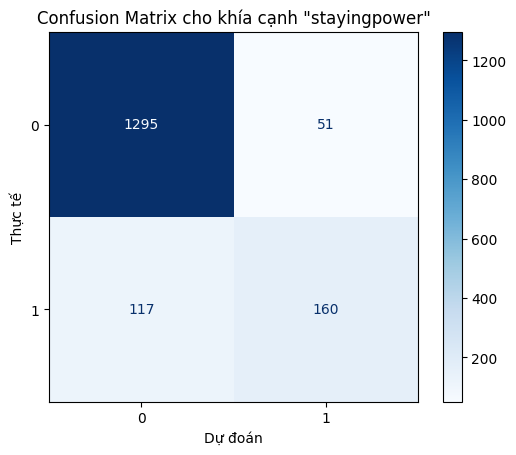


Confusion matrix cho khía cạnh 'texture':


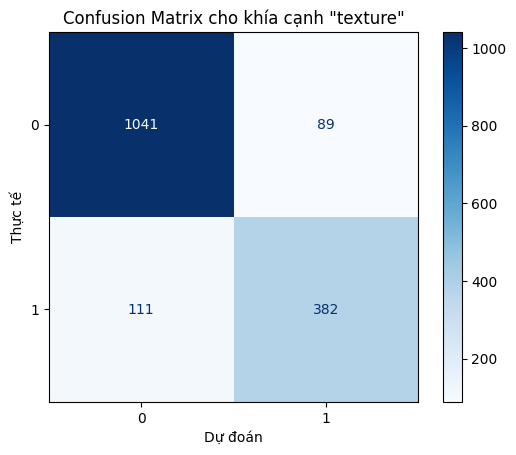


Confusion matrix cho khía cạnh 'smell':


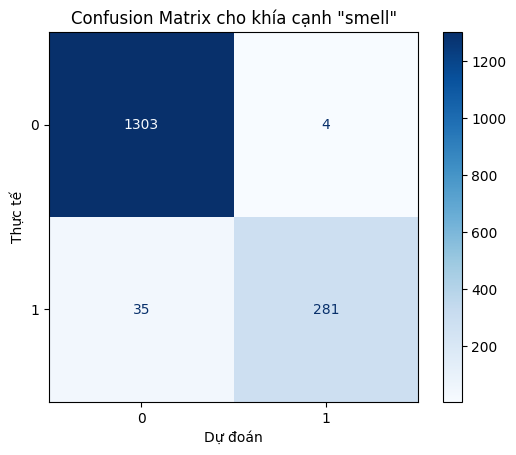


Confusion matrix cho khía cạnh 'price':


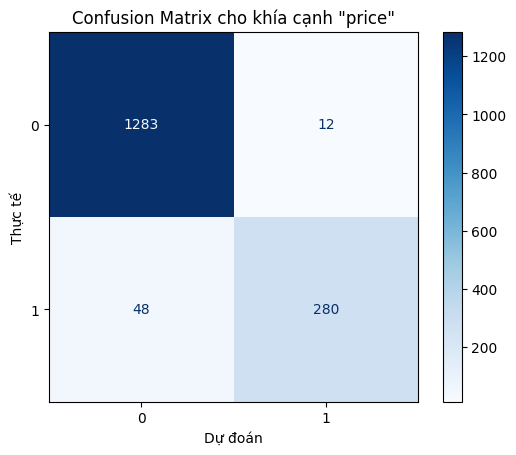


Confusion matrix cho khía cạnh 'others':


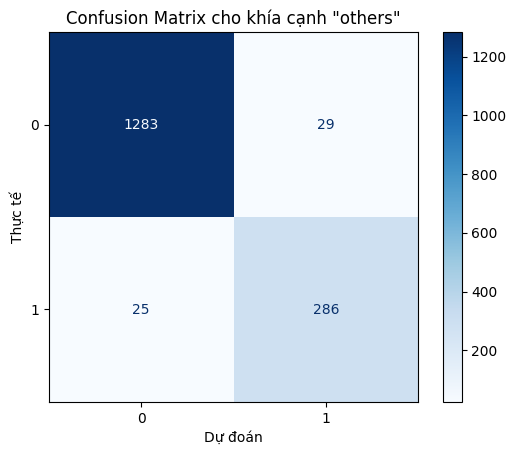


Confusion matrix cho khía cạnh 'colour':


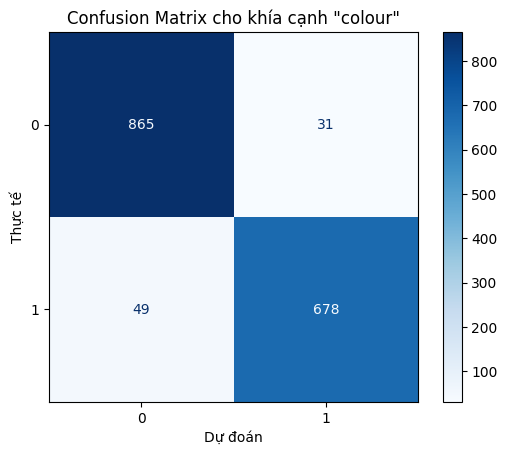


Confusion matrix cho khía cạnh 'shipping':


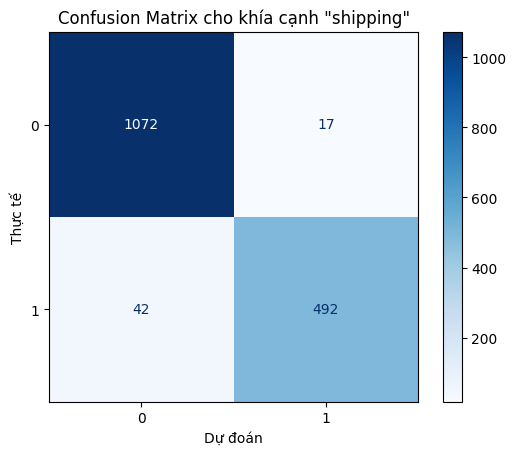


Confusion matrix cho khía cạnh 'packing':


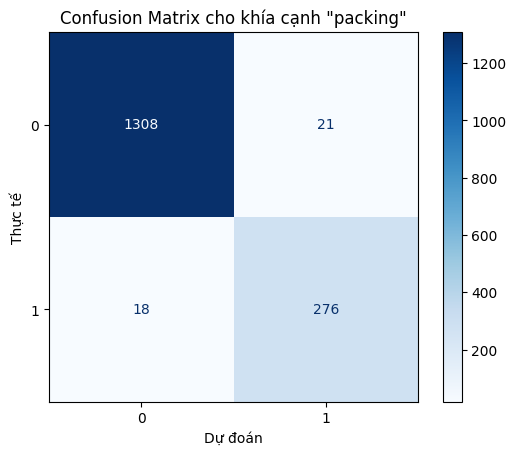

In [244]:
for aspect in aspects:
    idx = aspects.get_loc(aspect)  # nếu aspects là pandas.Index; dùng .index(aspect) nếu là list

    print(f"\nConfusion matrix cho khía cạnh '{aspect}':")

    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Hiển thị matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix cho khía cạnh \"{aspect}\"')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

# **BiGRU**

In [245]:
vectorizer = TextVectorization()
vectorizer.adapt(X_train)

X_train_BiGRU = vectorizer(X_train)
X_test_BiGRU = vectorizer(X_test)

In [246]:
vocab_size = len(vectorizer.get_vocabulary())

# Cấu hình BiGRU
BiGRU = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    Bidirectional(GRU(64)),
    Dense(len(aspect_labels), activation='sigmoid')
])

# Huấn luyện
BiGRU.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
BiGRU.fit(X_train_BiGRU, y_train_aspect)

# Dự đoán trên tập test
y_pred_aspect = BiGRU.predict(X_test_BiGRU)

406/406 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.2860 - loss: 0.4312
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [247]:
# Tính f1_score
y_pred_aspect = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")


F1_ad (Aspect Detection): 0.8032


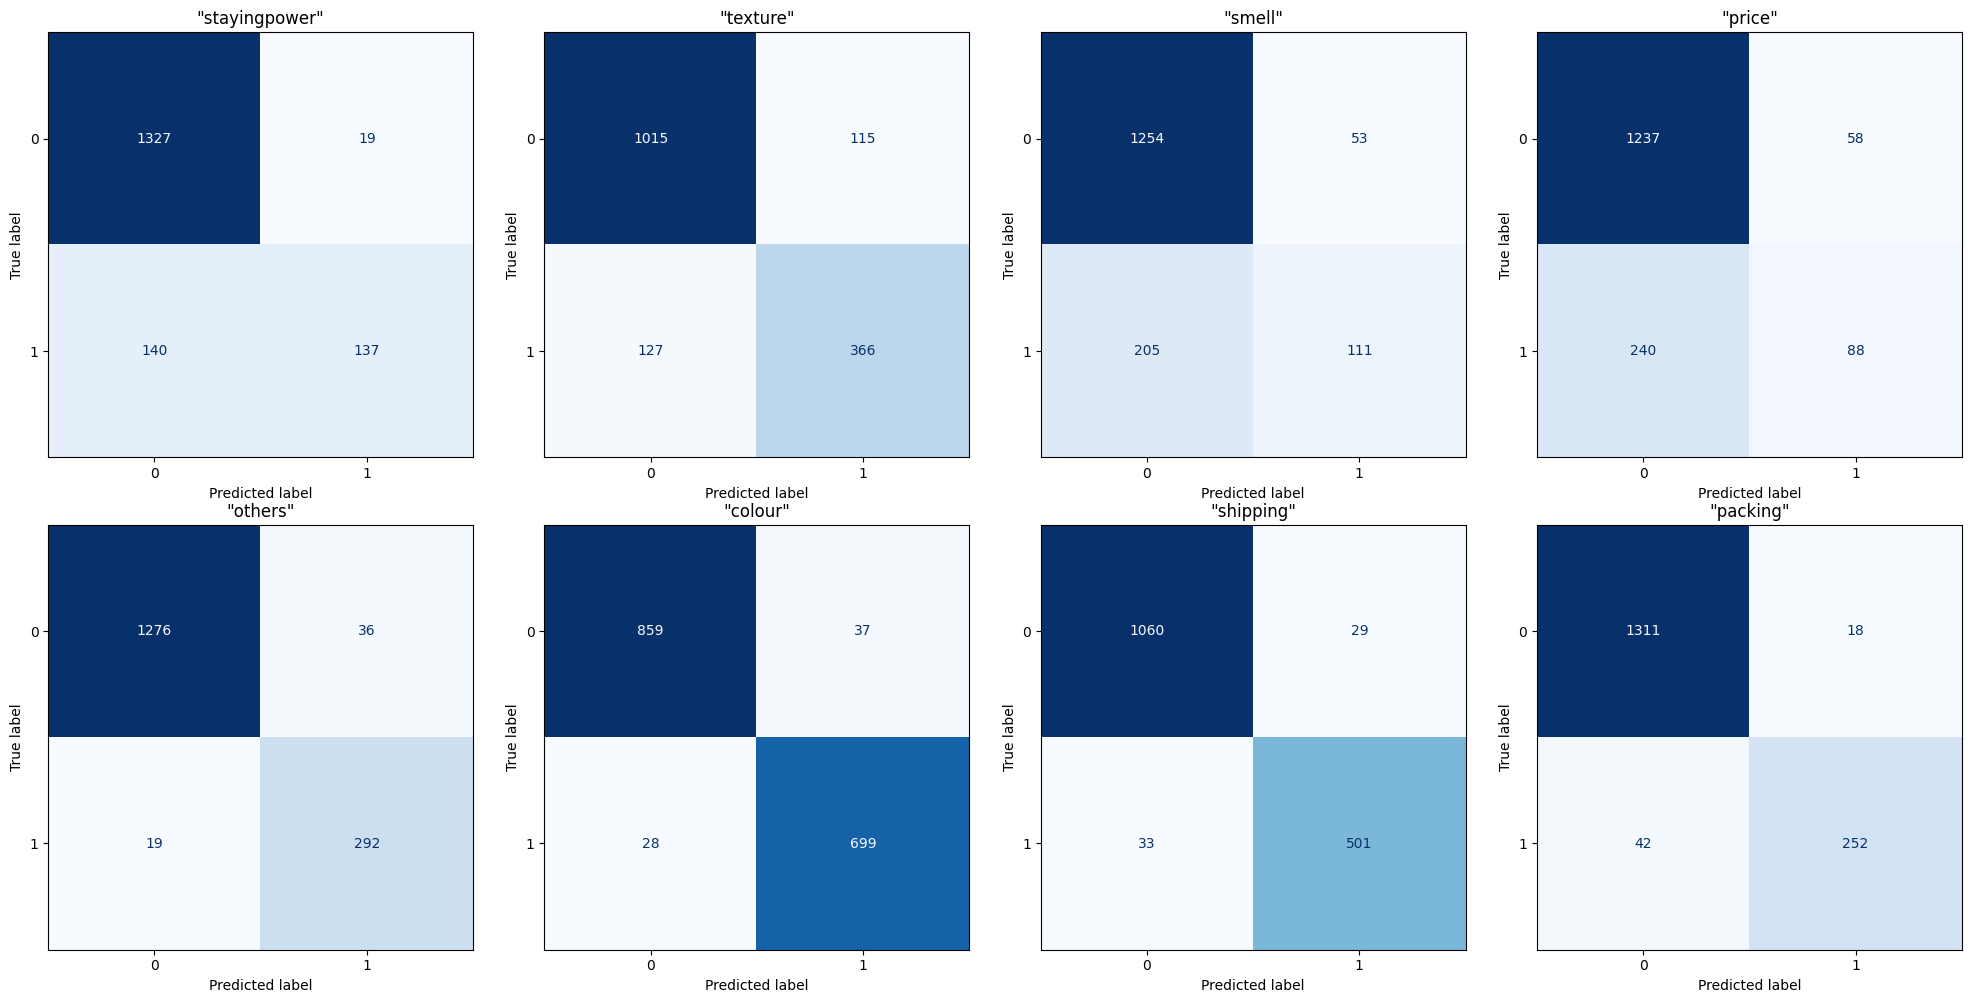

In [248]:
# Số cột mỗi hàng
cols = 4
total = len(aspects)
rows = (total + cols - 1) // cols 

# Tạo subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten() 

for i, aspect in enumerate(aspects):
    idx = aspects.get_loc(aspect)
    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'"{aspect}"')

# Tắt các ô trống nếu số khía cạnh không chia hết cho 4
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [249]:
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': -1}

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
  y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
  y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

pipeline_sentiment = {}

for aspect in aspects:
  mask_train = train_df[aspect + '_label'] == 1
  X_train_aspect = train_df[mask_train]
  y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]

  if len(X_train_aspect) > 0:
    BiGRU = Sequential([
        vectorizer,
        Embedding(input_dim=vocab_size, output_dim=100),
        Bidirectional(GRU(64)),
        Dense(3, activation='softmax')])
    
    # Dùng sparse_categorical_crossentropy vì y là số nguyên (0, 1, 2)
    BiGRU.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    BiGRU.fit(X_train_aspect['data'].astype(str).values, y_train_aspect_sentiment.values)

    pipeline_sentiment[aspect] = BiGRU

  else:
    pipeline_sentiment[aspect] = None

70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5243 - loss: 0.9653
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7240 - loss: 0.7781
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7419 - loss: 0.7399
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9579 - loss: 0.3432
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9624 - loss: 0.3258
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8167 - loss: 0.6048
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6684 - loss: 0.7640
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9185 - loss: 0.4221


In [250]:
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspects)), -1)

for i, aspect in enumerate(aspects):
    pipe = pipeline_sentiment[aspect]
    if pipe is not None:
        mask_pred = y_pred_aspect[:, i] == 1 
        if np.any(mask_pred):
            # Chuẩn hóa văn bản trước khi predict
            X_test_aspect = X_test[mask_pred].astype(str).values

            # Dự đoán sentiment
            y_pred_prob = pipe.predict(X_test_aspect)
            y_pred_label = np.argmax(y_pred_prob, axis=1)

            # Gán kết quả vào y_pred_sentiment
            y_pred_sentiment[mask_pred, i] = y_pred_label

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [251]:
f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] >= 0.5) & (y_test_sentiment[aspect] != -1) 
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, trung bình): {f1_sc:.4f}")

F1_sc (stayingpower): 0.5277
F1_sc (texture): 0.8129
F1_sc (smell): 0.8409
F1_sc (price): 0.9660
F1_sc (others): 1.0000
F1_sc (colour): 0.8201
F1_sc (shipping): 0.8502
F1_sc (packing): 0.9350

F1_sc (Sentiment Classification, trung bình): 0.8441


In [252]:
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')

f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)

In [253]:
# Kết quả 
f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0

print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")

F1_ad (Aspect Detection): 0.8032
F1_sc (Sentiment Classification): 0.8441



Confusion matrix cho khía cạnh 'stayingpower':


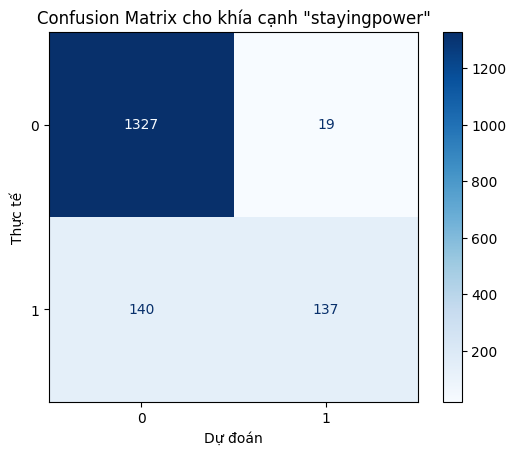


Confusion matrix cho khía cạnh 'texture':


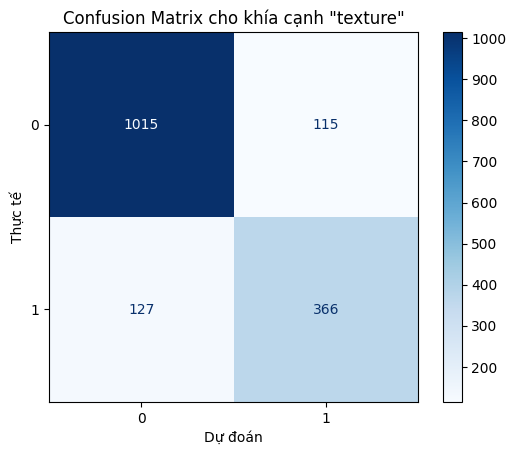


Confusion matrix cho khía cạnh 'smell':


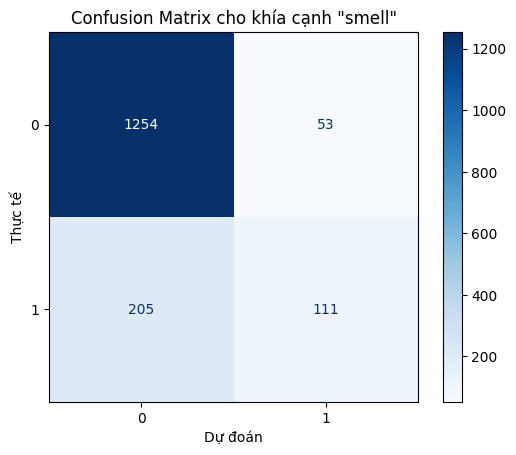


Confusion matrix cho khía cạnh 'price':


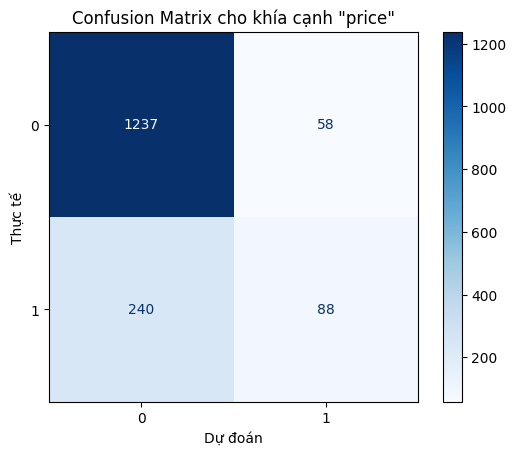


Confusion matrix cho khía cạnh 'others':


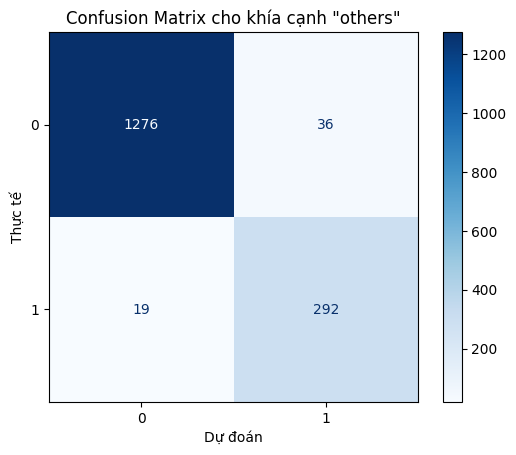


Confusion matrix cho khía cạnh 'colour':


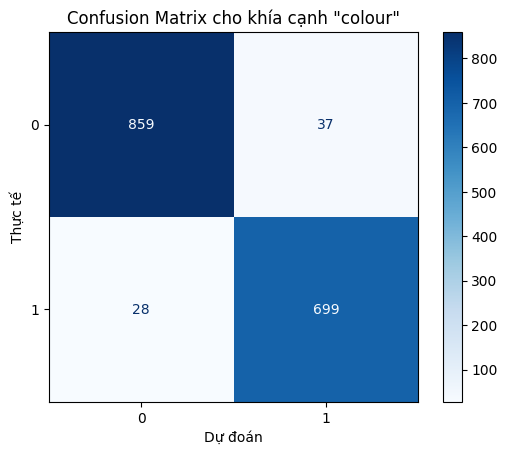


Confusion matrix cho khía cạnh 'shipping':


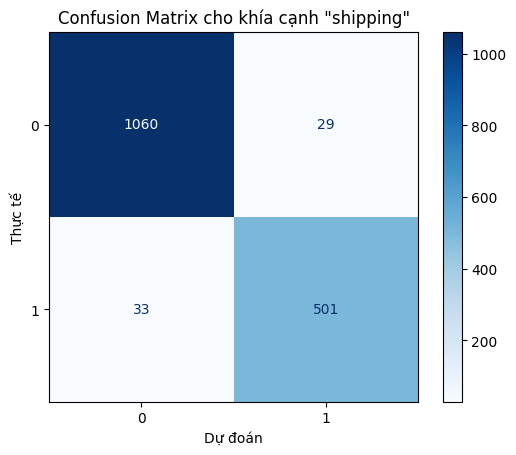


Confusion matrix cho khía cạnh 'packing':


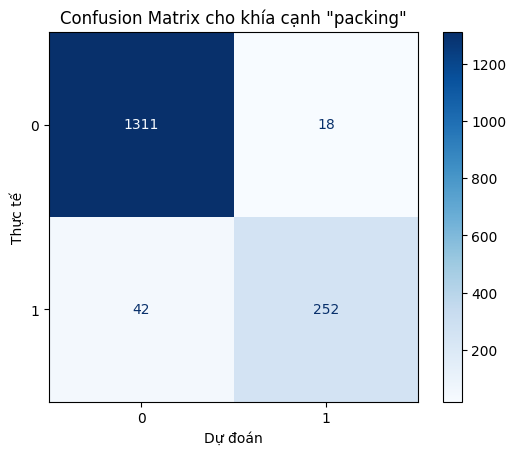

In [254]:
for aspect in aspects:
    idx = aspects.get_loc(aspect)  # nếu aspects là pandas.Index; dùng .index(aspect) nếu là list

    print(f"\nConfusion matrix cho khía cạnh '{aspect}':")

    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Hiển thị matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix cho khía cạnh \"{aspect}\"')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

# **BiLSTM + Conv1D**

In [255]:
vectorizer = TextVectorization()
vectorizer.adapt(X_train)

X_train_BiLSTM_Conv1D = vectorizer(X_train)
X_test_BiLSTM_Conv1D = vectorizer(X_test)

In [256]:
vocab_size = len(vectorizer.get_vocabulary())

# Cấu hình model: Embedding → BiLSTM → Conv1D → Dense
BiLSTM_Conv1D = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    
    # Trả về chuỗi đầu ra (nếu dùng Conv1D sau)
    Bidirectional(LSTM(64, return_sequences=True)),  
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    
    Dense(64, activation='relu'), # học đặc trưng phức tạp từ output trước 
    Dense(len(aspect_labels), activation='sigmoid') # lớp đầu ra trả về xác suất dự đoán cho từng khía cạnh
])


BiLSTM_Conv1D.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM_Conv1D.fit(X_train_BiLSTM_Conv1D, y_train_aspect)

# Dự đoán trên tập test
y_pred_aspect = BiLSTM_Conv1D.predict(X_test_BiLSTM_Conv1D)

406/406 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.2836 - loss: 0.4256
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [257]:
y_pred_aspect = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")


F1_ad (Aspect Detection): 0.9271


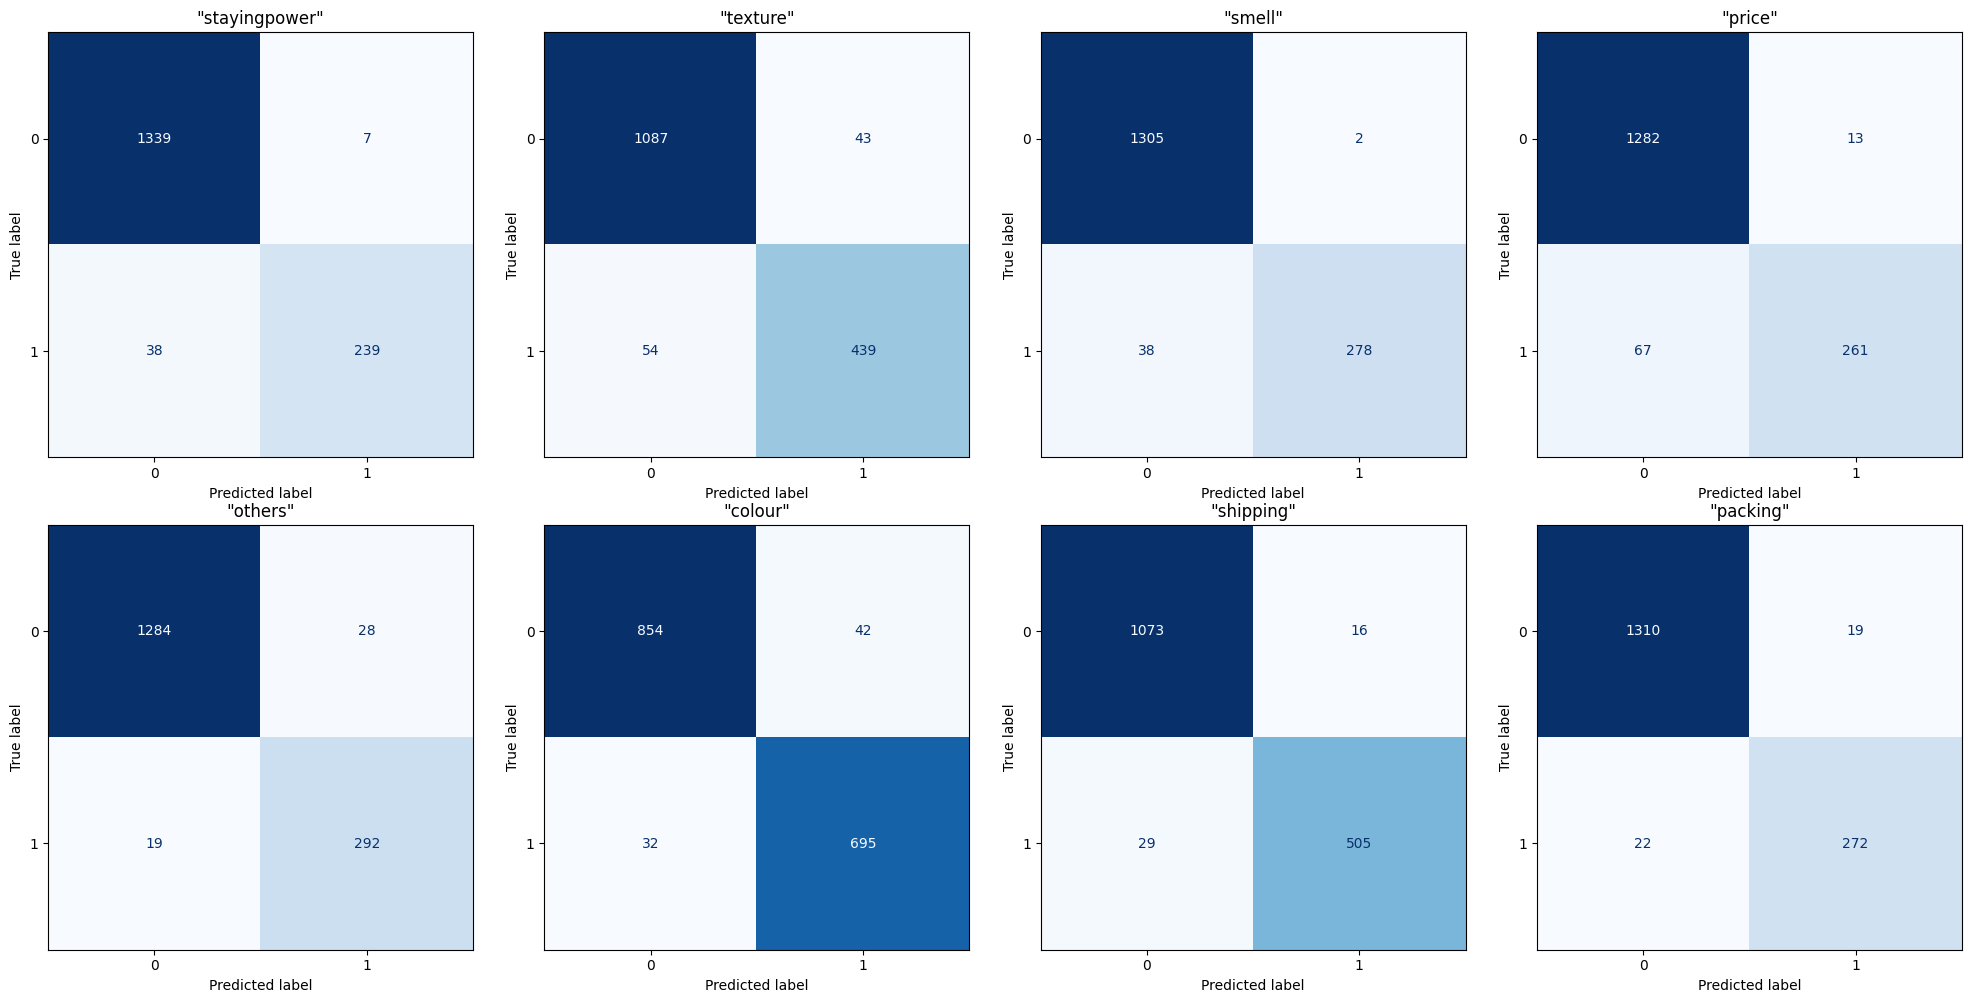

In [258]:
# Số cột mỗi hàng
cols = 4
total = len(aspects)
rows = (total + cols - 1) // cols 

# Tạo subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten() 

for i, aspect in enumerate(aspects):
    idx = aspects.get_loc(aspect)
    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'"{aspect}"')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [259]:
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': -1}

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
  y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
  y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

pipeline_sentiment = {}

for aspect in aspects:
  mask_train = train_df[aspect + '_label'] == 1
  X_train_aspect = train_df[mask_train]
  y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]

  if len(X_train_aspect) > 0:
    BiLSTM_Conv1D = Sequential([
        vectorizer,
        Embedding(input_dim=vocab_size, output_dim=100),

        Bidirectional(LSTM(64, return_sequences = True)),

        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),

        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Dùng sparse_categorical_crossentropy vì y là số nguyên (0, 1, 2)
    BiLSTM_Conv1D.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    BiLSTM_Conv1D.fit(X_train_aspect['data'].astype(str).values, y_train_aspect_sentiment.values)

    pipeline_sentiment[aspect] = BiLSTM_Conv1D

  else:
    pipeline_sentiment[aspect] = None

70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5498 - loss: 0.9707
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7148 - loss: 0.7749
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7693 - loss: 0.7174
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9674 - loss: 0.3149
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9282 - loss: 0.3018
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8243 - loss: 0.6088
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7055 - loss: 0.6915
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8974 - loss: 0.4403


In [260]:
f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] >= 0.5) & (y_test_sentiment[aspect] != -1) 
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, trung bình): {f1_sc:.4f}")

F1_sc (stayingpower): 0.3665
F1_sc (texture): 0.7288
F1_sc (smell): 0.4366
F1_sc (price): 0.4414
F1_sc (others): 0.9914
F1_sc (colour): 0.8227
F1_sc (shipping): 0.8423
F1_sc (packing): 0.8950

F1_sc (Sentiment Classification, trung bình): 0.6906


In [261]:
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')

f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)

In [262]:
# Kết quả 
f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0

print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")

F1_ad (Aspect Detection): 0.9271
F1_sc (Sentiment Classification): 0.6906



Confusion matrix cho khía cạnh 'stayingpower':


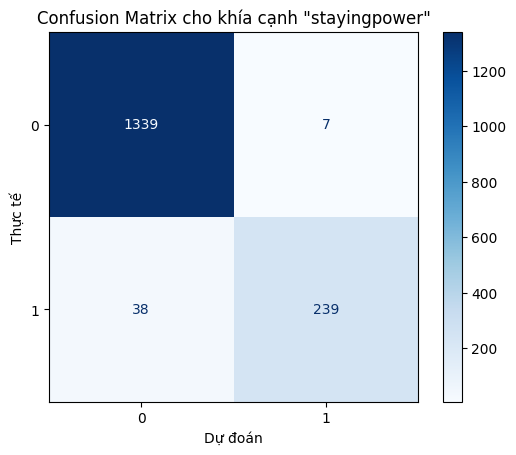


Confusion matrix cho khía cạnh 'texture':


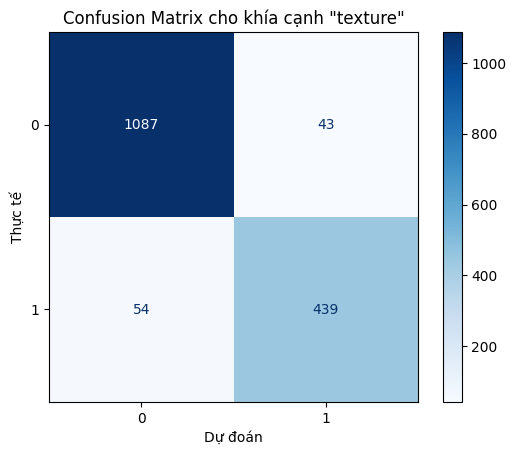


Confusion matrix cho khía cạnh 'smell':


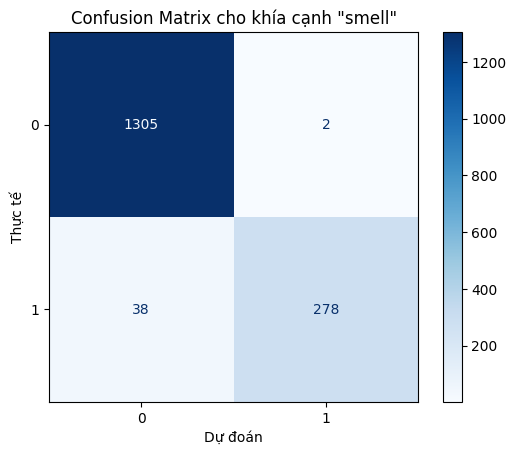


Confusion matrix cho khía cạnh 'price':


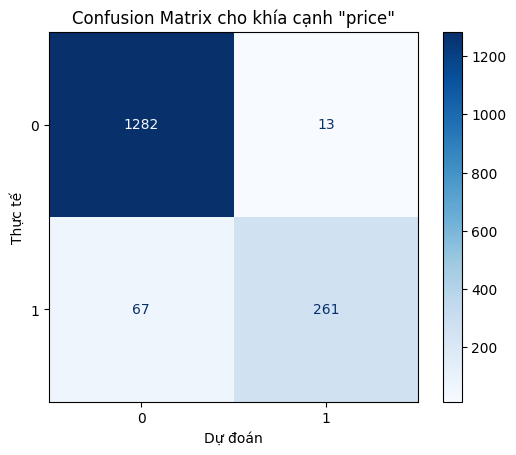


Confusion matrix cho khía cạnh 'others':


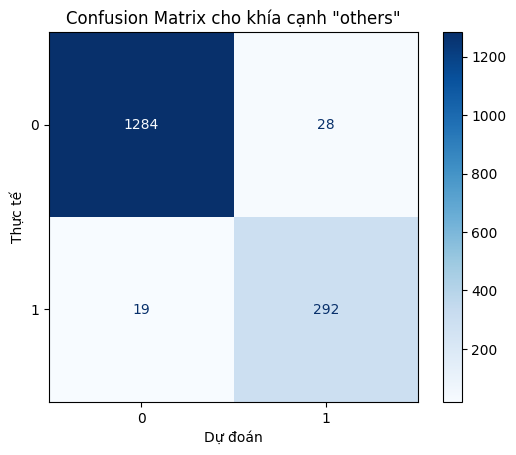


Confusion matrix cho khía cạnh 'colour':


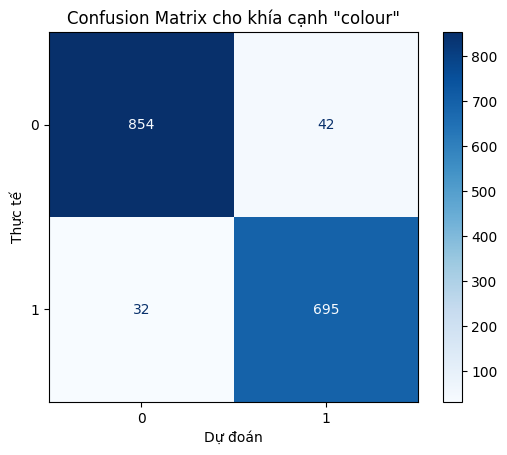


Confusion matrix cho khía cạnh 'shipping':


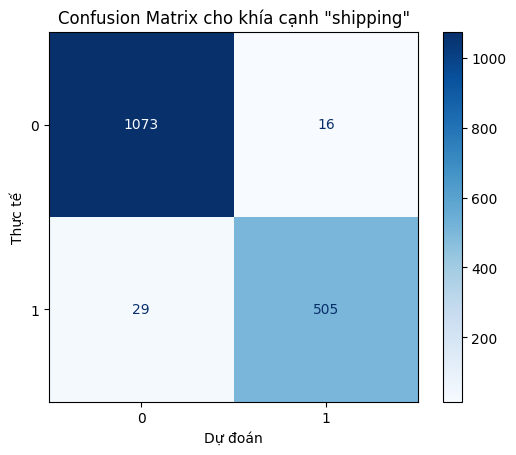


Confusion matrix cho khía cạnh 'packing':


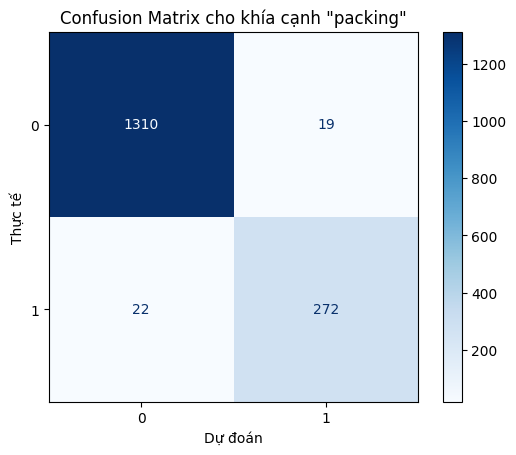

In [263]:
for aspect in aspects:
    idx = aspects.get_loc(aspect)  # nếu aspects là pandas.Index; dùng .index(aspect) nếu là list

    print(f"\nConfusion matrix cho khía cạnh '{aspect}':")

    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Hiển thị matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix cho khía cạnh \"{aspect}\"')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()